In [493]:
import os
import regex as re

First I unpacked .zip file and opened all files

In [494]:
directory = 'ustawy'

In [495]:
filenames = os.listdir('ustawy')

I gathered them to one dictionary, divided by year.
I also removed non-breaking space and soft-hypen to not disturb
_also_ in my work I use \s as you never know what white space was used and I often use + or * with them as there can be many of them

In [496]:
bills1 = {}
year_regex = r'(\d+)_\d+\.txt'


for filename in filenames:
    with open(os.path.join(directory, filename)) as f:
        bill = f.read()
        year = re.match(year_regex, filename).group(1)
        bill = bill.replace("\xa0", ' ').replace("\xad", '')
        
        if bills1.get(year, []):
            bills1[year].append(bill)
        else:
            bills1[year] = [bill]
            


I prepared functions to count expression occurences by year

In [497]:
def count_times_for_year(regex, year):
    counter = 0
    for bill in bills[year]:
        counter += len(re.findall(regex, bill))
    return counter

In [498]:
def count_times(regex):
    counter = {}
    for year in bills:
        counter[year] = count_times_for_year(regex, year)
    return counter

# TASK 1
For each bill compute the number of the following amendments present in the bill:

addition of a unit (e.g. dodaje się ust. 5a),

removal of a unit (e.g. w art. 10 ust. 1 pkt 8 skreśla się),

change of a unit (e.g. art. 5 otrzymuje brzmienie).

First, I removed any texts in "" because they were bills citations and I didn't mean to count phrases in citated bills, only original bills

In [499]:
quotation_regex = "\"[\s\S]*?\"" # any white or non-white sign in ""
bills = {k: [re.sub(quotation_regex, '', b) for b in v] for k, v in sorted(bills1.items(), key=lambda item: item[0])}

To avoid letter case sensitiveness I use (?i) in my regexes

## Addidtions

First I browsed through corpus and found what parts of bills are:
- art.
- lit.
- poz.
- ust.
- pkt
- §
- rozdział
- tytuł rozdziału
- zdanie wstępne
- zdanie końcowe

In [500]:
bill_parts = '(ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne)'

Sentences with additions:
- ust. 1 i dodaje się ust. 2-4 w brzmieniu:
- i dodaje się lit. e w brzmieniu:
- dodaje się nowy ust. 3 w brzmieniu:

so it's only 'dodaje się' or 'dodaje się nowy' and part of bill

In [501]:
addition_words = 'dodaje\ssię(\s+now(y|ą|e)\s*)?'


In [502]:
addition_regex = f'(?i){addition_words}(\s+{bill_parts})'

In [503]:
print(addition_regex)

(?i)dodaje\ssię(\s+now(y|ą|e)\s*)?(\s+(ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne))


## Removals

Sentences with removals:
- w pkt 3 skreśla się lit.c)
- skreśla się w ust. 1 pkt 5,
- art. 292 skreśla się.
- skreśla się art. 281 i 282{1};
- uchyla się ust. 1A,

Removals are more problematic as there are more cases.
For the beginning, I'll go for 'skreśla/uchyla się' followed by \<part name\>. So positive lookahead.

In [504]:
deletion_words = '((skreśla|uchyla)\s+się)'

In [505]:
deletion1 = f'{deletion_words}(?=\s+{bill_parts})'
# there is also very similar 'skreśla się w <part>' so I'll use 'w' as non-obligatory sign
deletion1 = f'{deletion_words}(\s+w)?(?=\s+{bill_parts})'

In [506]:
print(deletion1)

((skreśla|uchyla)\s+się)(\s+w)?(?=\s+(ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne))


Next I'll go for '\<bill part>\<bill part number> skreśla/uchyla się' or 'w \<bill part>\<bill part number> skreśla/uchyla się:'

So bill parts are followed deletion words and then again bill parts or :

As for numbers - there are many different kinds of them in bills:
- art. 2a
- pkt 1, 2 i 5
- pkt 2{1} - 5
- lit. f
- Tytuł V

In [507]:
# number with letter, e.g. 5a
letter = '\w'
number_reg = f'(\d+{letter}?)'
# there could be also numers like 5{1}
mustache = '(?:{\d+})'
number_reg = f'(\d+{letter}?{mustache}?)'
# it could be , and i
number_after_col = f'(\s*,\s*{number_reg})'
number_after_i = f'(\s*i\s*{number_reg})'
repetitive_number = f'{number_reg}{number_after_col}?{number_after_i}?'
# there could be also numbers after -
number_after_dash = f'(\s*-\s*{number_reg})'
whole_number = f'{number_reg}{number_after_col}?{number_after_i}?{number_after_dash}?'
# there could be also roman numbers or just letter
roman = '((I|V|X|D|C|M)+)'
after_part_regex = f'({whole_number}|{roman}|\w)'


In [508]:
deletion2 = f'w?\s*{bill_parts}\s+{after_part_regex}?(\s*{deletion_words})(?=\s*({bill_parts}|:|.|;|,))'

In [509]:
print(deletion2)

w?\s*(ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne)\s+((\d+\w?(?:{\d+})?)(\s*,\s*(\d+\w?(?:{\d+})?))?(\s*i\s*(\d+\w?(?:{\d+})?))?(\s*-\s*(\d+\w?(?:{\d+})?))?|((I|V|X|D|C|M)+)|\w)?(\s*((skreśla|uchyla)\s+się))(?=\s*((ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne)|:|.|;|,))


In [510]:
removal_regex = f'(?i){deletion1}|{deletion2}'

In [511]:
print(removal_regex)

(?i)((skreśla|uchyla)\s+się)(\s+w)?(?=\s+(ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne))|w?\s*(ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne)\s+((\d+\w?(?:{\d+})?)(\s*,\s*(\d+\w?(?:{\d+})?))?(\s*i\s*(\d+\w?(?:{\d+})?))?(\s*-\s*(\d+\w?(?:{\d+})?))?|((I|V|X|D|C|M)+)|\w)?(\s*((skreśla|uchyla)\s+się))(?=\s*((ust\.?|pkt\.?|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\s(rozdziału|ustawy))?|zdani(e)\skońcowe|zdanie\swstępne)|:|.|;|,))


In [512]:
# removal_regex = r'(?i)(skreśla\s+się|uchyla\s+się)(:?\s+w\s*)?(?=\s+(ust\.?|pkt|art\.?|§|lit\.?|poz\.?))|(:?w)?\s*(ust.|pkt|art.|§|lit.|poz.)\s+\d+\s+(skreśla\s+się|uchyla\s+się)(?=\s+(ust.|pkt|art.|§|lit.|poz.|:))|(?<!w )(ust\.|pkt|art\.|§|lit\.|poz\.)\s+\d+\s+(skreśla\s+się|uchyla\s+się)'

## Changes

Those sentences are like:
- dotychczasowa treść otrzymuje oznaczenie ust. 1,
- ust. 4 otrzymuje brzmienie:
- w ust. 5 pkt 1,5 i 2 otrzymują brzmienie:
- ust. 3a otrzymuje brzmienie:
- art. 86{7} otrzymuje brzmienie:
- art. 12 - 15 otrzymują brzmienie:
- zdanie wstępne otrzymuje brzmienie:
- lit. c otrzymuje brzmienie:

So there are typical bill parts and key words will be otrzymuje brzmienie/oznaczenie

In [513]:
# changes are like otrzymuje/ą brzmienie, otrzymują/e oznaczenie, nadaje się brzmienie/oznaczenie, oznacza się...,
# treść otrzymuje oznaczenie
changes_words = '(((\s*otrzymuj(?:ą|e)|nadaje\s+się)\s+)(brzmienie|oznaczenie))|oznacza\s+się'

change_regex = f'(?i){bill_parts}\s*{after_part_regex}?\s*{changes_words}'
print(changes_regex)

(?i)(ust\.?|pkt|art\.?|§|lit\.?|poz\.?|rozdział|tytuł(?:\srozdziału)?|zdanie\skońcowe|zdanie\swstępne)\s*((\d+\w?(?:{\d+})?)(\s*,\s*(\d+\w?(?:{\d+})?))?(\s*i\s*(\d+\w?(?:{\d+})?))?(\s*-\s*(\d+\w?(?:{\d+})?))?|((I|V|X|D|C|M)+)|\w)?\s*(((\s*otrzymuj(?:ą|e)|nadaje\s+się)\s+)(brzmienie|oznaczenie))|oznacza\s+się|(treść\s+otrzymuje\s+oznaczenie)


## Plot percentage

In [515]:
addition_count = count_times(addition_regex)
removal_count = count_times(removal_regex)
change_count = count_times(change_regex)
years = [year for year in bills]

In [516]:
addition_count = [addition_count[year] for year in years]
removal_count = [removal_count[year] for year in years]
change_count = [change_count[year] for year in years]
all_count = [addition_count[i] + removal_count[i] + change_count[i] for i in range(len(addition_count))]

In [517]:
print(sum(addition_count))
print(sum(removal_count))
print(sum(change_count))

5193
2388
8548


In [518]:
add_perc = [100 * addition_count[i] / all_count[i] for i in range(len(all_count))]
rem_perc = [100 * removal_count[i] / all_count[i] for i in range(len(all_count))]
change_perc = [100 * change_count[i] / all_count[i] for i in range(len(all_count))]

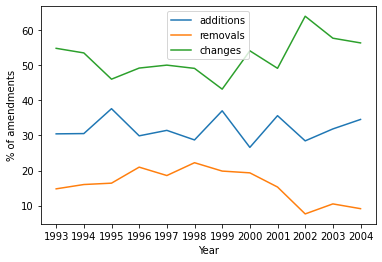

In [519]:
import matplotlib.pyplot as plt

plt.plot(years, add_perc, label = 'additions')
plt.plot(years, rem_perc, label = 'removals')
plt.plot(years, change_perc, label = 'changes')
plt.xlabel('Year')
plt.ylabel('% of amendments')
plt.legend()
plt.show()

# Task 2
Compute the total number of occurrences of the word ustawa in any inflectional form (ustawa, ustawie, ustawę, etc.) and all spelling forms (ustawa, Ustawa, USTAWA), excluding other words with the same prefix (e.g. ustawić).

Possible inflectional words: 
- ustawa, ustawy, ustawie, ustawę, ustawą, ustawo
- ustawy, ustaw, ustawom, ustawami, ustawach

topic: ustaw, ends: a,y,ie,ę,ą,o,0,om,ami,ach

It has to be case insensitive (?i) and I'm looking for a whole word so I use (\b) to set the borders

In [520]:
# back to data with texts from quotations
bills = {k: v for k, v in sorted(bills1.items(), key=lambda item: item[0])}

In [521]:
ends = ['a', 'y', 'ie', 'ę', 'ą', 'o', 'om', 'ami', 'ach']
topic = 'ustaw'
ends_regex = '|'.join(ends)
ends_regex

'a|y|ie|ę|ą|o|om|ami|ach'

## All ustawa occurences

In [522]:
ustawa_regex = f'(?i)\\b{topic}({ends_regex})?\\b'

In [523]:
print(ustawa_regex)

(?i)\bustaw(a|y|ie|ę|ą|o|om|ami|ach)?\b


In [524]:
ustawa_counts = count_times(ustawa_regex)
all_ustawa_counts = sum([ustawa_counts[year] for year in years])

All occurences:

In [525]:
all_ustawa_counts

24937

## Followed by 'z dnia' expression
followed so I'll use (?=) - positive lookahead

In [526]:
ustawa_followed_regex = f'(?i)\\b{topic}({ends_regex})?\\b(?=\s+z\s+dnia)'

In [527]:
print(ustawa_followed_regex)

(?i)\bustaw(a|y|ie|ę|ą|o|om|ami|ach)?\b(?=\s+z\s+dnia)


In [528]:
ustawa_followed_counts = count_times(ustawa_followed_regex)
all_ustawa_followed_counts = sum([ustawa_followed_counts[year] for year in years])

In [529]:
all_ustawa_followed_counts

8588

## Not followed by 'z dnia' expression
not followed so (?!) - negative lookahead

In [530]:
ustawa_not_followed_regex = f'(?i)\\b{topic}({ends_regex})?\\b(?!\s+z\s+dnia)'

In [531]:
print(ustawa_not_followed_regex)

(?i)\bustaw(a|y|ie|ę|ą|o|om|ami|ach)?\b(?!\s+z\s+dnia)


In [532]:
ustawa_not_followed_counts = count_times(ustawa_not_followed_regex)
all_ustawa_not_followed_counts = sum([ustawa_not_followed_counts[year] for year in years])

In [533]:
all_ustawa_not_followed_counts

16349

Quick check if control sum is correct - it is :)

In [534]:
all_ustawa_not_followed_counts + all_ustawa_followed_counts == all_ustawa_counts

True

# Task 3

Compute the total number of occurrences of the word ustawa in any inflectional form, excluding occurrences following o zmianie expression.

To exclude word following expression, (?<!) - negative lookbehind is used, it demands using fixed length of the word so I assume that there is only one white sign

In [535]:
ustawa_excluded_regex = f'(?i)\\b(?<!zmianie\s)\\b\\b{topic}({ends_regex})?\\b'

In [536]:
print(ustawa_excluded_regex)

(?i)\b(?<!zmianie\s)\b\bustaw(a|y|ie|ę|ą|o|om|ami|ach)?\b


In [537]:
ustawa_excluded_counts = count_times(ustawa_excluded_regex)
all_ustawa_excluded_counts = sum([ustawa_excluded_counts[year] for year in years])

In [538]:
all_ustawa_excluded_counts

24078

# Plotting 'ustawa'

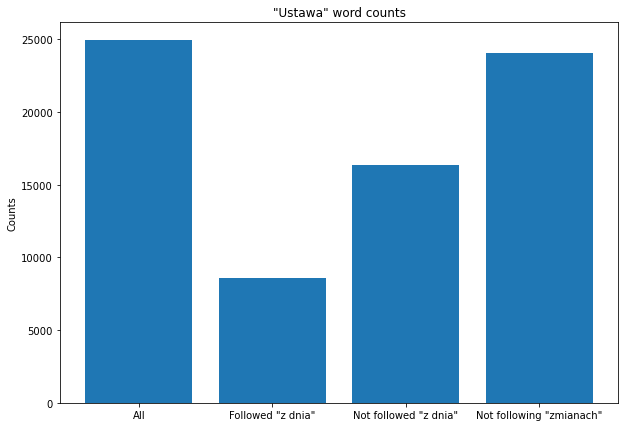

In [539]:
fig, ax = plt.subplots(figsize=(10,7))
labels = ['All', 'Followed "z dnia"', 'Not followed "z dnia"', 'Not following "zmianach"']
values = [all_ustawa_counts, all_ustawa_followed_counts, all_ustawa_not_followed_counts, all_ustawa_excluded_counts]
ax.bar(labels,values)
ax.set_ylabel('Counts')
ax.set_title('"Ustawa" word counts')



plt.show()